## Potential Talents - Part 6

----

## Candidates retriever using RAG + LLM

**Objective.** 

**Constraints.** 
- single GPU **GTX 1080 Ti (11GB)**
- rely on **NVMe** disk for offload/swap
- short sequences

**Model.** 
  

**Method (steps):**

1)
2)
3)


----


### 0. Imports, configuration and folders

In [1]:
import sys, torch
print("python:", sys.version)
print("torch:", torch.__version__, "| cuda:", torch.cuda.is_available())
try:
    import faiss
    print("faiss:", faiss.__version__)
except Exception as e:
    print("faiss import error:", e)


python: 3.10.18 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:08:55) [MSC v.1929 64 bit (AMD64)]
torch: 2.6.0+cu124 | cuda: True
faiss: 1.9.0


In [7]:
# core
import numpy as np
import pandas as pd
import re, os
import random
import tools_llm_ift

# display config
pd.set_option("display.max_colwidth", 200)
pd.set_option("display.width", 120)
pd.set_option("display.max_columns", 50)

In [8]:
tools_llm_ift.free_GPU_memory()

Measure memory usage before and after freeing it

Before:
allocated: 0.0 MiB | reserved: 0.0 MiB | total: 11,264 MiB

After:
allocated: 0.0 MiB | reserved: 0.0 MiB | total: 11,264 MiB


In [9]:
# GPU configuration details
print("torch:", torch.__version__)
print("built with CUDA:", torch.version.cuda)
print("cuda available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("gpu:", torch.cuda.get_device_name(0))

torch: 2.6.0+cu124
built with CUDA: 12.4
cuda available: True
gpu: NVIDIA GeForce GTX 1080 Ti


In [10]:
# reproducibility
SEED = 23
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# paths
DATA_DIR = "data"
OUT_DIR  = "outputs"

# datasets
base_ds_file = os.path.join(DATA_DIR, "extended_clean.csv")
extended_df_file = "Extended Dataset for Potential Talents.xlsx" 


----

### 1. Fast Exploring over the dataset

we import our already cleaned, normalized, curated and deduplicated dataset.

In [11]:
df = pd.read_csv(base_ds_file)
df.head()

,Unnamed: 0,id,title,location,screening_score,title_norm,title_len,alpha_ratio
0,0,1,innovative and driven professional seeking a role in data analyticsdata science in the information technology industry.,United States,100,innovative and driven professional seeking a role in data analyticsdata science in the information technology industry.,119.0,0.865546
1,1,2,ms applied data science student usc research assistant usc former data analytics intern at dr reddys laboratories former data science intern quadratyx actively seeking full time roles in summer 2025,United States,100,ms applied data science student usc research assistant usc former data analytics intern at dr reddys laboratories former data science intern quadratyx actively seeking full time roles in summer 2025,198.0,0.833333
2,2,3,computer science student seeking full-time software engineerdeveloper positions ai sql data visualization toolspython ssrs,United States,100,computer science student seeking full-time software engineerdeveloper positions ai sql data visualization toolspython ssrs,122.0,0.885246
3,3,4,microsoft certified power bi data analyst mba business analytics unt business intelligence engineer data scientist data engineer business analytics predictive analytics statistical analysis ex-eri...,United States,100,microsoft certified power bi data analyst mba business analytics unt business intelligence engineer data scientist data engineer business analytics predictive analytics statistical analysis ex-eri...,201.0,0.880597
4,4,5,graduate research assistant at uab masters in data science student at uab ex jio,United States,100,graduate research assistant at uab masters in data science student at uab ex jio,80.0,0.837500


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1199 entries, 0 to 1198
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       1199 non-null   int64  
 1   id               1199 non-null   int64  
 2   title            1199 non-null   object 
 3   location         1199 non-null   object 
 4   screening_score  1199 non-null   int64  
 5   title_norm       1199 non-null   object 
 6   title_len        1199 non-null   float64
 7   alpha_ratio      1199 non-null   float64
dtypes: float64(2), int64(3), object(3)
memory usage: 75.1+ KB


In [13]:
diff_rows = df[df['title'] != df['title_norm']]
diff_rows.value_counts

<bound method DataFrame.value_counts of Empty DataFrame
Columns: [Unnamed: 0, id, title, location, screening_score, title_norm, title_len, alpha_ratio]
Index: []>

The `title_norm` column is not adding information, then we will keep the `id` and `title` columns only.

In [14]:
df_slim = df.loc[:,('id','title')].copy()

In [15]:
df_slim.head()

,id,title
0,1,innovative and driven professional seeking a role in data analyticsdata science in the information technology industry.
1,2,ms applied data science student usc research assistant usc former data analytics intern at dr reddys laboratories former data science intern quadratyx actively seeking full time roles in summer 2025
2,3,computer science student seeking full-time software engineerdeveloper positions ai sql data visualization toolspython ssrs
3,4,microsoft certified power bi data analyst mba business analytics unt business intelligence engineer data scientist data engineer business analytics predictive analytics statistical analysis ex-eri...
4,5,graduate research assistant at uab masters in data science student at uab ex jio


----

### 2. Indexing - SBERT embeddings + FAISS

In [75]:
from sentence_transformers import SentenceTransformer
from pathlib import Path
import pyarrow, fastparquet
from pprint import pprint
from math import log2


In [24]:
# Folders and SBERT model
EMB_MODEL = 'sentence-transformers/all-mpnet-base-v2'
INDEX_DIR = Path(OUT_DIR) / "rag_index"
INDEX_DIR.mkdir(parents=True, exist_ok=True)

In [27]:
# Source of data
texts = df_slim['title'].astype(str).tolist()
len(texts)

1199

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"
sbert = SentenceTransformer(EMB_MODEL, device=device)
sbert.max_seq_length = 256  # plenty for the titles (max = 213 chars)

In [30]:
# Encode (L2-normalize -> cosine == dot product)
emb = sbert.encode(
    texts,
    batch_size=128,
    show_progress_bar=True,
    normalize_embeddings=True,
    convert_to_numpy=True,
).astype(np.float32)


Batches: 100%|██████████| 10/10 [00:01<00:00,  5.86it/s]


In [ ]:
# Build FAISS exact inner-product index
d = emb.shape[1]
print(f"Embeddings' dimmension: {d}")
index = faiss.IndexFlatIP(d)
index.add(emb)

In [ ]:
# FAISS artifacts
np.save(INDEX_DIR / "embeddings.npy", emb)  # handy for checks
df_slim.to_parquet(INDEX_DIR / "titles.parquet", index=False, engine="fastparquet")
faiss.write_index(index, str(INDEX_DIR / "flatip.index"))

In [ ]:
!dir /B ".\outputs\rag_index"

In [ ]:
info = {
    "vectors": int(emb.shape[0]),
    "dim": int(d),
    "index_type": "IndexFlatIP (exact cosine)",
    "saved": {
        "faiss_index": str(INDEX_DIR / "flatip.index"),
        "embeddings": str(INDEX_DIR / "embeddings.npy"),
        "titles": str(INDEX_DIR / "titles.parquet"),
    }
}

pprint(info, sort_dicts=False, width=80)

#### 2.1.1 Artifacts created — Embedding Index (SBERT + FAISS)

After embedding the `title` column and building the FAISS index, three files were written under `./outputs/rag_index`:

- **`flatip.index`** FAISS binary index (type: `IndexFlatIP`).  
  - Stores the vector database for **exact cosine** search (we normalized vectors, so cosine ≡ inner product).  
  - Used at query time to search fast without recomputing all dot products in Python.

- **`embeddings.npy`** NumPy matrix of L2-normalized embeddings (shape: `N × D`).  
  - Helpful for **sanity checks**, analytics, or quickly **rebuilding** an index with different FAISS parameters.  
  - Row **i** in this array corresponds **exactly** to row **i** in `titles.parquet`.

- **`titles.parquet`** Metadata table (at least `id` and `title`).  
  - Holds the original client titles **unchanged**.  
  - Provides the mapping from FAISS vector IDs to human-readable titles and their internal IDs.  
  
> **Invariant:** For all `i`, `embeddings[i]` ↔ `titles.parquet.iloc[i]`. This alignment is what lets us return intact titles after FAISS search.

In [ ]:
# check unit norms
row_norm_mean = np.linalg.norm(emb, axis=1).mean()
print("mean L2 norm (should be ~1.0):", round(float(row_norm_mean), 6))

In [ ]:
# self search on first vector

%time D, I = index.search(emb[:1], 50)

CPU times: total: 0 ns
Wall time: 0 ns


In [ ]:
print("top-50 indices for item 0:\t", I[0].tolist())
print("top-50 sims: \t\t\t", [round(float(x), 4) for x in D[0]])

top-50 indices for item 0:	 [0, 417, 527, 792, 26, 192, 1195, 412, 907, 471, 498, 485, 131, 525, 639, 273, 981, 18, 342, 982, 110, 173, 999, 994, 43, 318, 289, 49, 1097, 263, 442, 233, 98, 1099, 274, 1067, 144, 399, 90, 1118, 528, 1186, 658, 742, 305, 405, 1180, 292, 127, 1047]
top-50 sims: 			 [1.0, 0.7692, 0.7682, 0.7452, 0.7313, 0.7273, 0.7174, 0.7171, 0.7117, 0.709, 0.7073, 0.7061, 0.7053, 0.7022, 0.6905, 0.6874, 0.6822, 0.6815, 0.6807, 0.6801, 0.6769, 0.6761, 0.6758, 0.6756, 0.6746, 0.6731, 0.6713, 0.6691, 0.6671, 0.6666, 0.6663, 0.6659, 0.6654, 0.6651, 0.6645, 0.6595, 0.6585, 0.6573, 0.6563, 0.6544, 0.6542, 0.6531, 0.652, 0.6513, 0.65, 0.6495, 0.6494, 0.6489, 0.6488, 0.6488]


#### 2.1 - Experimenting with two main FAISS indexing systems **IndexFlatIP** (exact cosine similarity) and **IndexIVFFlat** (centroid based)

Recommended short youtube video from James Briggs explaning how FAISS works: 

**Faiss - Introduction to Similarity Search** https://www.youtube.com/watch?v=sKyvsdEv6rk&list=LL&index=2

In [67]:
# baseline queries used in previous project parts
QUERIES = ["data scientist", "machine learning engineer", "backend developer", "product manager"]


In [76]:
# Build exact FAISS index (cosine via inner product. Embeddings are L2-normalized)
d = emb.shape[1]
index = faiss.IndexFlatIP(d)
index.add(emb)

In [77]:
# Encode queries
q_emb = sbert.encode(
    QUERIES, 
    batch_size=4, 
    show_progress_bar=False,
    normalize_embeddings=True, 
    convert_to_numpy=True
).astype(np.float32)

In [69]:
# we will inspect the top-k results
k = 10  

#### 2.1.1 - **IndexFlatIP** (exact cosine similarity)

In [78]:
def time_search(index, queries, k, warmup=1):
    # FAISS warmup
    for _ in range(warmup):
        index.search(queries[:min(4, len(queries))], k)
    
    # tic time and search using the index    
    t0 = time.perf_counter()
    D, I = index.search(queries, k)
    t1 = time.perf_counter()
    elapsed = t1 - t0
    
    # return D,I from the FAISS search, the elapsed time and stats
    return D, I, elapsed, {"elapsed_s": elapsed, "qps": len(queries)/max(elapsed,1e-9), "ms_per_query": 1000*elapsed/len(queries)}


In [79]:
# Results using: IndexFlatIP (exact)
D_flat, I_flat, t_flat, tflat_stats = time_search(index, q_emb, k, warmup=1)

print("\n=-=-=-=-= Exact (IndexFlatIP) =-=-=-=-=")
for qi, q in enumerate(QUERIES):
    print(f"\nQuery: {q!r}")
    print("I (indices):", I_flat[qi].tolist())
    print("D (scores): ", [round(float(x), 4) for x in D_flat[qi]])
print("\nExact timing:", {k: (round(v,4) if isinstance(v,float) else v) for k,v in tflat_stats.items()})



=-=-=-=-= Exact (IndexFlatIP) =-=-=-=-=

Query: 'data scientist'
I (indices): [194, 1097, 405, 1018, 72, 1085, 474, 435, 623, 880]
D (scores):  [1.0, 0.9188, 0.9148, 0.8806, 0.8755, 0.8676, 0.8645, 0.8632, 0.8574, 0.8553]

Query: 'machine learning engineer'
I (indices): [891, 979, 1140, 1155, 23, 259, 191, 995, 374, 984]
D (scores):  [1.0, 0.8641, 0.8493, 0.8411, 0.8002, 0.7841, 0.7743, 0.765, 0.7562, 0.756]

Query: 'backend developer'
I (indices): [812, 819, 291, 785, 574, 1067, 776, 1193, 692, 1156]
D (scores):  [0.6172, 0.617, 0.5975, 0.5885, 0.5711, 0.5574, 0.552, 0.5454, 0.5441, 0.5418]

Query: 'product manager'
I (indices): [697, 707, 513, 732, 167, 841, 243, 450, 983, 819]
D (scores):  [0.6857, 0.6128, 0.5853, 0.5713, 0.5686, 0.539, 0.5317, 0.5123, 0.5006, 0.4843]

Exact timing: {'elapsed_s': 0.0005, 'qps': 8262.7558, 'ms_per_query': 0.121}


#### 2.1.2 - **IndexIVFFlat** (centroid based)

In [80]:
# IVF (IndexIVFFlat): test nlist in {32, 64, 128} and nprobe in {4, 8, 16}
# where:
#   nlist:  number of coarse clusters
#   nprobe: clusters to search (trade-off: higher = better recall, slower)
#

N = emb.shape[0]
d = emb.shape[1]

candidate_nlist  = [x for x in (32, 64, 128) if x < N]
candidate_nprobe = [4, 8, 16]

#### Helper functions to compare retrieval quality
These helpers compute:
- **nDCG@k**: ranking quality metric comparing the retrieved order (using similarity scores from the exact baseline as gains)
- **Recall@k**: overlap metric measuring how many of the top-k exact results are also found by the approximate method (ANN)

In [88]:
def dcg(gains):
    """Discounted cumulative gain: sum(g_i / log2(i+2))."""
    return sum(float(g) / log2(i + 2) for i, g in enumerate(gains))


def ndcg_at_k_vs_exact(I_exact, D_exact, I_method, k):
    """
    Compute nDCG@k comparing an approximate method to the exact baseline.
    Uses the exact similarities (D_exact) as relevance gains.
    """
    nQ = I_exact.shape[0]
    out = np.zeros(nQ, dtype=np.float32)
    for q in range(nQ):
        base_idx = I_exact[q, :k]
        base_gain = D_exact[q, :k]
        gain_map = {int(i): float(g) for i, g in zip(base_idx, base_gain)}
        ideal = dcg([gain_map[int(i)] for i in base_idx])
        method_idx = I_method[q, :k]
        actual = dcg([gain_map.get(int(i), 0.0) for i in method_idx])
        out[q] = 0.0 if ideal == 0 else actual / ideal
    return out


def recall_at_k_vs_exact(I_exact, I_method, k):
    """
    Compute Recall@k as the fraction of top-k exact results
    also retrieved by the approximate method.
    """
    nQ = I_exact.shape[0]
    out = np.zeros(nQ, dtype=np.float32)
    for q in range(nQ):
        out[q] = len(set(map(int, I_exact[q, :k])) & set(map(int, I_method[q, :k]))) / k
    return out


In [89]:
rows = []
# iterate over the nb of clusters (nlist)
for nlist in candidate_nlist:
    quantizer = faiss.IndexFlatIP(d)
    ivf = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_INNER_PRODUCT)
    ivf.train(emb)
    ivf.add(emb)

    # iterate over the nb of cluster to search
    for nprobe in candidate_nprobe:
        ivf.nprobe = min(nprobe, nlist)

        D_ivf, I_ivf, t_ivf, tivf_stats = time_search(ivf, q_emb, k, warmup=1)

        # print retrieved neighbors for quick eyeballing
        print(f"\n=-=-=-=-= IVF (nlist={nlist}, nprobe={ivf.nprobe}) =-=-=-=-=")
        for qi, q in enumerate(QUERIES):
            print(f"\nQuery: {q!r}")
            print("I:", I_ivf[qi].tolist())
            print("D:", [round(float(x), 4) for x in D_ivf[qi]])
        print("Timing:", {k: (round(v,4) if isinstance(v,float) else v) for k,v in tivf_stats.items()})

        # metrics vs exact
        recall10 = recall_at_k_vs_exact(I_flat, I_ivf, k=10).mean()
        ndcg10   = ndcg_at_k_vs_exact(I_flat, D_flat, I_ivf, k=10).mean()

        rows.append({
            "run": f"IVF(nlist={nlist},nprobe={ivf.nprobe})",
            "Recall@10": float(recall10),
            "nDCG@10":   float(ndcg10),
            "elapsed_s": float(tivf_stats["elapsed_s"]),
            "ms_per_query": float(tivf_stats["ms_per_query"]),
            "qps": float(tivf_stats["qps"]),
        })



=-=-=-=-= IVF (nlist=32, nprobe=4) =-=-=-=-=

Query: 'data scientist'
I: [194, 1097, 405, 1018, 72, 1085, 474, 435, 623, 880]
D: [1.0, 0.9188, 0.9148, 0.8806, 0.8755, 0.8676, 0.8645, 0.8632, 0.8574, 0.8553]

Query: 'machine learning engineer'
I: [891, 979, 1140, 1155, 23, 259, 191, 995, 374, 984]
D: [1.0, 0.8641, 0.8493, 0.8411, 0.8002, 0.7841, 0.7743, 0.765, 0.7562, 0.756]

Query: 'backend developer'
I: [812, 819, 291, 785, 574, 1067, 776, 692, 1156, 916]
D: [0.6172, 0.617, 0.5975, 0.5885, 0.5711, 0.5574, 0.552, 0.5441, 0.5418, 0.5351]

Query: 'product manager'
I: [697, 707, 167, 841, 243, 450, 983, 716, 387, 114]
D: [0.6857, 0.6128, 0.5686, 0.539, 0.5317, 0.5123, 0.5006, 0.4795, 0.4622, 0.4608]
Timing: {'elapsed_s': 0.0001, 'qps': 63592.9913, 'ms_per_query': 0.0157}

=-=-=-=-= IVF (nlist=32, nprobe=8) =-=-=-=-=

Query: 'data scientist'
I: [194, 1097, 405, 1018, 72, 1085, 474, 435, 623, 880]
D: [1.0, 0.9188, 0.9148, 0.8806, 0.8755, 0.8676, 0.8645, 0.8632, 0.8574, 0.8553]

Query: 'mac

#### 2.1.3 - Summary table + quick visuals (latency & quality trade-off)

In [90]:
import matplotlib.pyplot as plt

In [92]:
# Build/collect the summary DataFrame

# helper forcing float values
def _safe(v, default=np.nan):
    try:
        return float(v)
    except Exception:
        return default

exact_row = {
    "run": "Exact(IndexFlatIP)",
    "Recall@10": 1.0,
    "nDCG@10": 1.0,
    "elapsed_s": _safe(tflat_stats.get("elapsed_s")),
    "ms_per_query": _safe(tflat_stats.get("ms_per_query")),
    "qps": _safe(tflat_stats.get("qps")),
}

try:
    df_ivf = pd.DataFrame(rows)  # from IVF loop (contains Recall@10, nDCG@10, ms_per_query, qps)
except NameError:
    df_ivf = pd.DataFrame(columns=["run","Recall@10","nDCG@10","elapsed_s","ms_per_query","qps"])

summary = pd.concat([pd.DataFrame([exact_row]), df_ivf], ignore_index=True)

# Nice formatting for display
summary_disp = summary.copy()
for col in ["Recall@10","nDCG@10"]:
    if col in summary_disp:
        summary_disp[col] = summary_disp[col].map(lambda x: None if pd.isna(x) else f"{x:.3f}")
for col in ["ms_per_query","qps","elapsed_s"]:
    if col in summary_disp:
        summary_disp[col] = summary_disp[col].map(lambda x: None if pd.isna(x) else f"{x:.3f}")

print("=-=-=-= Retrieval Summary =-=-=-=")
print(summary_disp.fillna("").to_string(index=False))



=-=-=-= Retrieval Summary =-=-=-=
                     run Recall@10 nDCG@10 elapsed_s ms_per_query       qps
      Exact(IndexFlatIP)     1.000   1.000     0.000        0.121  8262.756
  IVF(nlist=32,nprobe=4)     0.900   0.937     0.000        0.016 63592.991
  IVF(nlist=32,nprobe=8)     0.925   0.952     0.000        0.029 35056.969
 IVF(nlist=32,nprobe=16)     0.975   0.983     0.000        0.039 25906.734
  IVF(nlist=64,nprobe=4)     0.700   0.805     0.000        0.023 43196.555
  IVF(nlist=64,nprobe=8)     0.775   0.857     0.000        0.018 55478.505
 IVF(nlist=64,nprobe=16)     0.925   0.952     0.000        0.030 33003.295
 IVF(nlist=128,nprobe=4)     0.800   0.873     0.000        0.015 68728.515
 IVF(nlist=128,nprobe=8)     0.850   0.905     0.000        0.015 67340.049
IVF(nlist=128,nprobe=16)     0.925   0.951     0.000        0.022 45610.035


Refs:
- Recall@10: fraction of true top-10 results retrieved 
- nDCG@10: ranking quality vs. ideal order
- elapsed_s: total search time in seconds
- ms_per_query: average milliseconds per query
- qps: queries processed per second

### Reading the Retrieval Summary

- **Exact(IndexFlatIP)** is the gold standard: by definition it gets **Recall@10 = 1.0** and **nDCG@10 = 1.0**.  
  Latency here is ~**0.121 ms/query** (~**8.3k QPS**).
  
- **IVF (centroid-based)** trades recall for speed by probing only a subset of clusters (`nprobe`).  
  - With **nlist=32, nprobe=16**, we are at **nDCG@10 ≈ 0.983** and **Recall@10 ≈ 0.975** while being ~**3× faster** than Exact (**0.039 ms/query**).  
  - With **nlist=128, nprobe=8–16**, we are at **nDCG@10 ≈ 0.905–0.951** and **0.015–0.022 ms/query** (much faster), with small quality loss.  
  - **nlist=64** underperforms at low `nprobe` here (coarser partitioning didn’t align well with the data), but recovers as `nprobe` increases.

- **Speed–quality sweet spots (for this dataset)**  
  - **Balanced:** `nlist=32, nprobe=16` near-exact quality, 3× faster.  
  - **Speed-focused:** `nlist=128, nprobe=8` → ~**0.015 ms/query** and **nDCG@10 ≈ 0.905**.



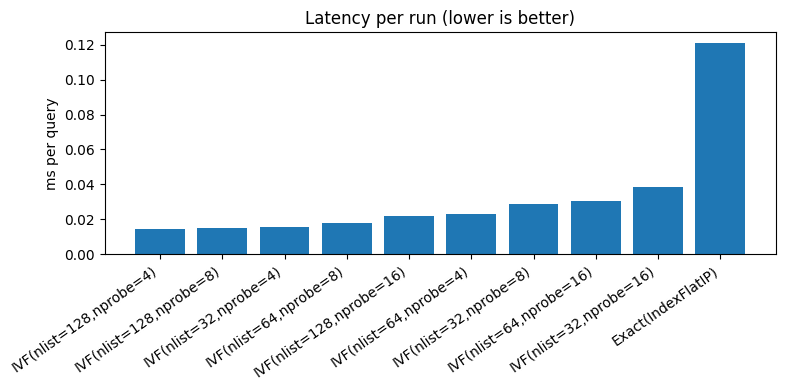

In [93]:
# Plot: latency (ms/query) by run
plt.figure(figsize=(8, 4))
order = summary.sort_values("ms_per_query", na_position="last")["run"]
vals = summary.set_index("run").loc[order, "ms_per_query"]
plt.bar(order, vals)
plt.ylabel("ms per query")
plt.title("Latency per run (lower is better)")
plt.xticks(rotation=35, ha="right")
plt.tight_layout()
plt.show()


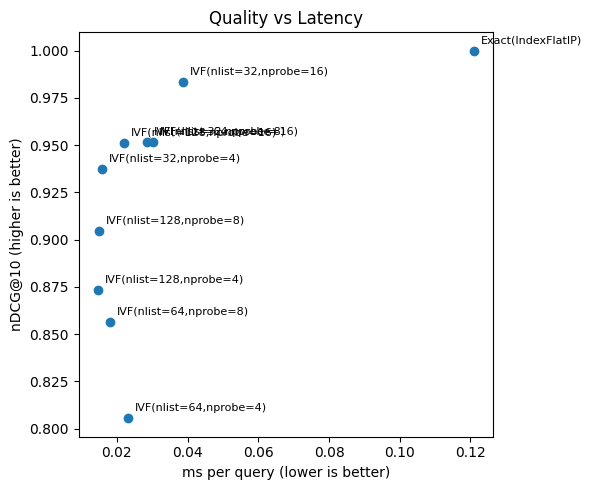

In [94]:
# Plot: nDCG@10 vs ms/query (quality–latency trade-off)
# Points closer to top-left are better!
if "nDCG@10" in summary and "ms_per_query" in summary and summary["nDCG@10"].notna().any():
    plt.figure(figsize=(6, 5))
    x = summary["ms_per_query"]
    y = summary["nDCG@10"]
    plt.scatter(x, y)
    for i, name in enumerate(summary["run"]):
        if not (pd.isna(x.iloc[i]) or pd.isna(y.iloc[i])):
            plt.annotate(name, (x.iloc[i], y.iloc[i]), xytext=(5, 5), textcoords="offset points", fontsize=8)
    plt.xlabel("ms per query (lower is better)")
    plt.ylabel("nDCG@10 (higher is better)")
    plt.title("Quality vs Latency")
    plt.tight_layout()
    plt.show()
else:
    print("\n(nDCG/Recall not available — run the IVF loop that computes metrics to enable this plot.)")


**Conclusion:**  
The chart shows that approximate search methods (IVF) achieve **near-perfect quality (nDCG@10 ≈ 0.95–0.98)** while being **3–8× faster** than the exact `IndexFlatIP`.  
Increasing `nprobe` improves quality with a modest latency cost, and configurations like **IVF (nlist = 32–128, nprobe = 8–16)** offer the best balance between **accuracy and speed**.


#### 3 - RAG 

In my configuration the **“RAG”** = title DB + SBERT embeddings + FAISS (IVF) index + a retriever + a prompt builder that feeds the LLM.

#### 3.1 - Prepare a simple retrieval function

In [95]:
# Build IVF index (cosine via inner product. Embeddings already L2-normalized)
d = emb.shape[1]
nlist, nprobe = 32, 16  # use the sweet spot values

quantizer = faiss.IndexFlatIP(d)
ivf = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_INNER_PRODUCT)
ivf.train(emb)
ivf.add(emb)
ivf.nprobe = nprobe


In [121]:
def _to_df(I_row, D_row, meta_df, top_n):
    """
    Build a tidy DataFrame for the top-N retrieval results.

    Args:
        I_row (array-like): 1D array of retrieved indices for a single query (length >= top_n).
        D_row (array-like): 1D array of similarity scores aligned with `I_row` (length >= top_n).
        meta_df (pd.DataFrame): Metadata table where row i maps to candidate i; must contain a 'title' column.
        top_n (int): Number of top results to include (N).

    Returns:
        pd.DataFrame: Columns ["rank","index","score","title"] for the top-N hits in ranked order.
    """
    rows = []
    for r, (idx, score) in enumerate(zip(I_row[:top_n], D_row[:top_n]), start=1):
        title = meta_df.iloc[int(idx)]["title"] if idx != -1 else "<none>"
        rows.append({"rank": r, "index": int(idx), "score": float(score), "title": title})
    return pd.DataFrame(rows, columns=["rank","index","score","title"])


def retrieve(query: str, top_n: int = 20, return_df: bool = True):
    """
    Encode a text query, retrieve top-N nearest neighbors with IVF, and return results + timing.

    Args:
        query (str): Text query to embed and search.
        top_n (int, optional): Number of nearest neighbors to return (N). Defaults to 20.
        return_df (bool, optional): If True, return a tidy DataFrame; otherwise return raw (I, D). Defaults to True.

    Returns:
        Tuple[pd.DataFrame | Tuple[np.ndarray, np.ndarray], Dict[str, float]]:
            - If return_df=True: (df_results, stats)
                * df_results (pd.DataFrame): ["rank","index","score","title"] for the top-N hits.
            - If return_df=False: ((I, D), stats)
                * I (np.ndarray): 1D array of top-N indices.
                * D (np.ndarray): 1D array of top-N similarity scores.
            - stats (dict): {"ms_per_query": float} latency in milliseconds.
    """
    q = sbert.encode([query], normalize_embeddings=True, convert_to_numpy=True).astype(np.float32)
    t0 = time.perf_counter()
    D, I = ivf.search(q, top_n)
    elapsed_ms = (time.perf_counter() - t0) * 1000.0
    if return_df:
        df_out = _to_df(I[0], D[0], df_slim, top_n)
        return df_out, {"ms_per_query": elapsed_ms}
    return (I[0], D[0]), {"ms_per_query": elapsed_ms}


In [122]:
# quick sanity check on the 4 baseline queries
for q in QUERIES:
    df_out, stats = retrieve(q, top_n=10, return_df=True)
    print(f"\nQuery: {q!r} | {stats['ms_per_query']:.3f} ms")
    display(df_out)


Query: 'data scientist' | 0.417 ms


,rank,index,score,title
0,1,194,1.000000,data scientist
1,2,1097,0.918813,data analyst data scientist
2,3,405,0.914789,data scientist analyst
3,4,1018,0.880559,data scientistgeoscientist
4,5,72,0.875535,data analyst
5,6,1085,0.867643,mathematician data scientist
6,7,474,0.864531,data science enthusiast
7,8,435,0.863215,data scientist i
8,9,623,0.857368,data specialist
9,10,880,0.855288,data scientist ms data science



Query: 'machine learning engineer' | 0.185 ms


,rank,index,score,title
0,1,891,1.000000,machine learning engineer
1,2,979,0.864124,machine learning engineer 2
2,3,1140,0.849322,Data Scientist Machine Learning Engineer
3,4,1155,0.841134,Machine Learning Engineer Data Scientist MLOps
4,5,23,0.800220,data analyst and machine learning engineer
5,6,259,0.784138,machine learning engineer genworth masters in computer sciences
6,7,191,0.774341,ai engineer
7,8,995,0.764983,ai engineer data scientist
8,9,374,0.756230,machine learning operations engineer at spyglaz
9,10,984,0.755988,data scientist data analyst machine learning engineer



Query: 'backend developer' | 0.318 ms


,rank,index,score,title
0,1,812,0.617170,full-stack developer
1,2,819,0.617032,software developer
2,3,291,0.597493,Software Engineer
3,4,785,0.588457,full-stack software developer
4,5,574,0.571139,software engineer.
5,6,1067,0.557379,web development data analyst data scientist
6,7,776,0.552043,software engineer full stack developer javascript typescript node react angular java spring boot hibernate mysqlmongodb aws
7,8,1193,0.545444,MLOps Machine Learning Backend Dev FastAPI Data Scientist Data Analyst
8,9,692,0.544082,devops assistant at guglielmo associates
9,10,1156,0.541794,Data Software Engineer



Query: 'product manager' | 0.327 ms


,rank,index,score,title
0,1,697,0.685709,performance marketing manager
1,2,707,0.612830,program manager
2,3,732,0.571285,senior data growth product manager cdp management product analytics mcit penn
3,4,167,0.568613,aspiring product manager information systems graduate with a strong technical background passionate about driving innovation and solving complex problems
4,5,841,0.539026,operations manager assistant program coordinator
5,6,243,0.531720,associate manager
6,7,450,0.512335,business analyst at inventory management solutions
7,8,983,0.500584,technology consultant
8,9,819,0.484297,software developer
9,10,574,0.483594,software engineer.


#### 3.2 - RAG prompt composer (uses IVF retriever)

In [123]:
def compose_context(df_hits, max_items: int = 8):
    """
    Convert retrieved titles into a compact markdown-like context block.

    Args:
        df_hits (pd.DataFrame): Output of `_to_df` (top-N hits).
        max_items (int, optional): Max rows to include in the context. Defaults to 8.

    Returns:
        str: Multiline bullet list with [index], title, and score.
    """
    rows = []
    for _, r in df_hits.head(max_items).iterrows():
        rows.append(f"- [{r['index']}] {r['title']} (score: {r['score']:.3f})")
    return "\n".join(rows)


def build_prompt(query: str, top_n: int = 20, max_items: int = 8, top_k: int = 10):
    """
    Retrieve top-N with IVF and compose a short prompt for an LLM.

    Args:
        query (str): User/job query.
        top_n (int, optional): N neighbors to retrieve from the index. Defaults to 20.
        max_items (int, optional): Max items from the top-N to show as context. Defaults to 8.
        top_k (int, optional): K items the LLM should return (K ≤ N). Defaults to 10.

    Returns:
        Tuple[str, pd.DataFrame, Dict[str, float]]:
            - prompt (str): Ready-to-send LLM prompt containing the query and retrieved context.
            - df_hits (pd.DataFrame): Top-N hits (columns: ["rank","index","score","title"]).
            - stats (dict): {"ms_per_query": float} retrieval latency in ms.
    """
    df_hits, stats = retrieve(query, top_n=top_n, return_df=True)

    # Guards to keep things consistent
    max_items = max(1, min(max_items, len(df_hits)))   # 1..N
    top_k_eff = max(1, min(top_k, max_items))          # 1..max_items (≤ N)

    context = compose_context(df_hits, max_items=max_items)
    prompt = (
        "You are helping select candidate profiles from short titles.\n"
        "Use the retrieved titles below as your only evidence.\n"
        "Be concise and return a short, ranked shortlist that best matches the query.\n\n"
        f"Query: {query}\n\n"
        f"Retrieved titles:\n{context}\n\n"
        f"Task: Return the {top_k_eff} best-matching titles with one-line rationale each."
    )
    return prompt, df_hits, stats



In [131]:
# quick demo (no LLM call yet)
MAX_TOKENS_BEFORE_TUNCATE = 5000
for q in QUERIES:
    prompt, hits, t = build_prompt(q, top_n=20, max_items=8, top_k=10)
    print(f"\n=-=-=-= Prompt for {q!r} (retrieval {t['ms_per_query']:.3f} ms) =-=-=-=\n")
    print(prompt[:MAX_TOKENS_BEFORE_TUNCATE] + ("\n... [truncated]" if len(prompt) > MAX_TOKENS_BEFORE_TUNCATE else ""))



=-=-=-= Prompt for 'data scientist' (retrieval 0.208 ms) =-=-=-=

You are helping select candidate profiles from short titles.
Use the retrieved titles below as your only evidence.
Be concise and return a short, ranked shortlist that best matches the query.

Query: data scientist

Retrieved titles:
- [194] data scientist (score: 1.000)
- [1097] data analyst data scientist (score: 0.919)
- [405] data scientist analyst (score: 0.915)
- [1018] data scientistgeoscientist (score: 0.881)
- [72] data analyst (score: 0.876)
- [1085] mathematician data scientist (score: 0.868)
- [474] data science enthusiast (score: 0.865)
- [435] data scientist i (score: 0.863)

Task: Return the 8 best-matching titles with one-line rationale each.

=-=-=-= Prompt for 'machine learning engineer' (retrieval 0.164 ms) =-=-=-=

You are helping select candidate profiles from short titles.
Use the retrieved titles below as your only evidence.
Be concise and return a short, ranked shortlist that best matches the que

### RAG -> LLM: build prompt, call ChatGPT <img src="./sup_imgs/ChatGPT-Logo.svg.webp" width="45" style="vertical-align: middle;"/> and parse shortlist

In [125]:
from openai import OpenAI
from dotenv import load_dotenv

In [126]:
load_dotenv()  # keys stored in .env file
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
if not OPENAI_API_KEY:
    raise RuntimeError("OPENAI_API_KEY is not set. Add it to your .env or environment.")


In [127]:
client_oa = OpenAI(api_key=OPENAI_API_KEY)

# default model
OPENAI_MODEL_ID = os.getenv("OPENAI_MODEL_ID", "gpt-4o")

In [128]:

def ask_chatgpt_with_context(query: str, *, top_n: int = 20, top_k: int = 8,
                             model: str = OPENAI_MODEL_ID, temperature: float = 0.0,
                             max_tokens: int = 600) -> Tuple[str, pd.DataFrame, Dict[str, float]]:
    """
    End-to-end:
      1) retrieve top-N with IVF (the retriever),
      2) build the prompt (short context),
      3) call ChatGPT,
      4) return (llm_text, df_hits, stats).
    """
    prompt, df_hits, rstats = build_prompt(query, top_n=top_n, max_items=top_k, top_k=top_k)
    t0 = time.perf_counter()
    resp = client_oa.chat.completions.create(
        model=model,
        temperature=temperature,
        max_tokens=max_tokens,
        messages=[{"role": "user", "content": prompt}],
    )
    elapsed_ms = (time.perf_counter() - t0) * 1000.0
    text = (resp.choices[0].message.content or "").strip()
    stats = {
        "retrieval_ms": float(rstats["ms_per_query"]),
        "llm_ms": float(elapsed_ms),
        "total_ms": float(rstats["ms_per_query"] + elapsed_ms),
        "model": model,
        "temperature": temperature,
        "top_n": top_n,
        "top_k": top_k,
    }
    return text, df_hits, stats


def parse_llm_shortlist(text: str, df_hits: pd.DataFrame, k: int) -> pd.DataFrame:
    """
    Parse a short list from ChatGPT output.
    Strategy:
      - Prefer bracketed indices like [123]
      - Fallback: match titles fuzzily against df_hits['title']
      - Keep top-k rows in order of appearance
    Returns: DataFrame with columns ["rank","index","title","rationale"]
    """
    lines = [ln.strip() for ln in text.splitlines() if ln.strip()]
    picks = []
    used = set()

    # Try to extract [index] first
    for ln in lines:
        m = re.search(r"\[(\d+)\]", ln)
        if m:
            idx = int(m.group(1))
            if idx not in used and (0 <= idx < len(df_slim)):
                title = df_slim.iloc[idx]["title"]
                rationale = re.sub(r"^\d+[\).\-\s]*", "", ln)  # strip leading "1) - " patterns
                picks.append({"index": idx, "title": title, "rationale": rationale})
                used.add(idx)
        if len(picks) >= k:
            break

    # Fallback: fuzzy title contains (very light)
    if len(picks) < k:
        low_map = {t.lower(): (i, t) for i, t in zip(df_hits["index"], df_hits["title"])}
        for ln in lines:
            tl = ln.lower()
            for t_low, (idx, title) in low_map.items():
                if t_low in tl and idx not in used:
                    picks.append({"index": int(idx), "title": title, "rationale": ln})
                    used.add(idx)
                    break
            if len(picks) >= k:
                break

    # If still short, pad from top-N retrieval order
    if len(picks) < k:
        for _, r in df_hits.iterrows():
            idx = int(r["index"])
            if idx not in used:
                picks.append({"index": idx, "title": r["title"], "rationale": "(from retrieval)"})
                used.add(idx)
            if len(picks) >= k:
                break

    out = pd.DataFrame(picks[:k])
    out.insert(0, "rank", np.arange(1, len(out) + 1))
    return out.loc[:, ["rank", "index", "title", "rationale"]]


In [132]:
# Quick demo using the baseline QUERIES
for q in QUERIES:
    llm_text, df_hits, stats = ask_chatgpt_with_context(q, top_n=20, top_k=8)
    print(f"\n=== {q!r} | retrieval {stats['retrieval_ms']:.3f} ms | LLM {stats['llm_ms']:.1f} ms ===\n")
    print(llm_text[:MAX_TOKENS_BEFORE_TUNCATE] + ("\n... [truncated]" if len(llm_text) > MAX_TOKENS_BEFORE_TUNCATE else ""))

    shortlist = parse_llm_shortlist(llm_text, df_hits, k=5)
    display(shortlist)



=== 'data scientist' | retrieval 0.201 ms | LLM 3255.8 ms ===

1. [194] data scientist (score: 1.000)  
   - Exact match for the query "data scientist."

2. [1097] data analyst data scientist (score: 0.919)  
   - Strong match with both "data analyst" and "data scientist" roles included.

3. [405] data scientist analyst (score: 0.915)  
   - Combines "data scientist" with "analyst," closely aligning with the query.

4. [1018] data scientistgeoscientist (score: 0.881)  
   - Contains "data scientist" and suggests a specialized field, which may be relevant.

5. [1085] mathematician data scientist (score: 0.868)  
   - Includes "data scientist" and indicates a strong quantitative background.

6. [435] data scientist i (score: 0.863)  
   - Variant of "data scientist" with a potential entry-level designation.

7. [474] data science enthusiast (score: 0.865)  
   - Indicates a strong interest in data science, though not a professional title.

8. [72] data analyst (score: 0.876)  
   - Rela

,rank,index,title,rationale
0,1,194,data scientist,[194] data scientist (score: 1.000)
1,2,1097,data analyst data scientist,[1097] data analyst data scientist (score: 0.919)
2,3,405,data scientist analyst,[405] data scientist analyst (score: 0.915)
3,4,1018,data scientistgeoscientist,[1018] data scientistgeoscientist (score: 0.881)
4,5,1085,mathematician data scientist,[1085] mathematician data scientist (score: 0.868)



=== 'machine learning engineer' | retrieval 0.279 ms | LLM 3807.1 ms ===

1. [891] machine learning engineer (score: 1.000)  
   - Exact match with the query, indicating a perfect fit.

2. [979] machine learning engineer 2 (score: 0.864)  
   - Direct match with a slight variation, suggesting a similar role with potential seniority.

3. [1140] Data Scientist Machine Learning Engineer (score: 0.849)  
   - Combines machine learning engineering with data science, closely aligning with the query.

4. [1155] Machine Learning Engineer Data Scientist MLOps (score: 0.841)  
   - Includes machine learning engineering and additional relevant skills in data science and MLOps.

5. [23] data analyst and machine learning engineer (score: 0.800)  
   - Directly mentions machine learning engineer, though combined with data analyst responsibilities.

6. [259] machine learning engineer genworth masters in computer sciences (score: 0.784)  
   - Direct mention of machine learning engineer, with additio

,rank,index,title,rationale
0,1,891,machine learning engineer,[891] machine learning engineer (score: 1.000)
1,2,979,machine learning engineer 2,[979] machine learning engineer 2 (score: 0.864)
2,3,1140,Data Scientist Machine Learning Engineer,[1140] Data Scientist Machine Learning Engineer (score: 0.849)
3,4,1155,Machine Learning Engineer Data Scientist MLOps,[1155] Machine Learning Engineer Data Scientist MLOps (score: 0.841)
4,5,23,data analyst and machine learning engineer,[23] data analyst and machine learning engineer (score: 0.800)



=== 'backend developer' | retrieval 0.203 ms | LLM 2711.0 ms ===

1. [1193] MLOps Machine Learning Backend Dev FastAPI Data Scientist Data Analyst  
   - Contains "Backend Dev," directly matching the query for a backend developer.

2. [819] software developer  
   - A general title that includes backend development as a core responsibility.

3. [291] Software Engineer  
   - Broad engineering role that often encompasses backend development tasks.

4. [574] software engineer.  
   - Similar to the above, this role typically involves backend development work.

5. [812] full-stack developer  
   - Includes backend development as part of the full-stack skill set.

6. [785] full-stack software developer  
   - Implies backend development experience as part of the full-stack role.

7. [776] software engineer full stack developer javascript typescript node react angular java spring boot hibernate mysqlmongodb aws  
   - Lists backend technologies like Java, Spring Boot, and databases, indica

,rank,index,title,rationale
0,1,1193,MLOps Machine Learning Backend Dev FastAPI Data Scientist Data Analyst,[1193] MLOps Machine Learning Backend Dev FastAPI Data Scientist Data Analyst
1,2,819,software developer,[819] software developer
2,3,291,Software Engineer,[291] Software Engineer
3,4,574,software engineer.,[574] software engineer.
4,5,812,full-stack developer,[812] full-stack developer



=== 'product manager' | retrieval 0.232 ms | LLM 3501.9 ms ===

1. [732] senior data growth product manager cdp management product analytics mcit penn (score: 0.571)  
   - Directly mentions "product manager," indicating a relevant role.

2. [167] aspiring product manager information systems graduate with a strong technical background passionate about driving innovation and solving complex problems (score: 0.569)  
   - Explicitly states "aspiring product manager," showing clear intent and alignment with the query.

3. [707] program manager (score: 0.613)  
   - While not a product manager, the role of program manager often overlaps with product management responsibilities.

4. [697] performance marketing manager (score: 0.686)  
   - High score and managerial experience, which can be relevant to product management.

5. [841] operations manager assistant program coordinator (score: 0.539)  
   - Includes managerial and coordination roles, which can be relevant to product management.



,rank,index,title,rationale
0,1,732,senior data growth product manager cdp management product analytics mcit penn,[732] senior data growth product manager cdp management product analytics mcit penn (score: 0.571)
1,2,167,aspiring product manager information systems graduate with a strong technical background passionate about driving innovation and solving complex problems,[167] aspiring product manager information systems graduate with a strong technical background passionate about driving innovation and solving complex problems (score: 0.569)
2,3,707,program manager,[707] program manager (score: 0.613)
3,4,697,performance marketing manager,[697] performance marketing manager (score: 0.686)
4,5,841,operations manager assistant program coordinator,[841] operations manager assistant program coordinator (score: 0.539)
